In [88]:
import numpy as np
import matplotlib.pyplot as plt

from alpub_autoencoder.autoencoder_utils import read_alpub_data
from PIL import Image

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
ALPUB_PATH = '../Datasets/alpub_v2/images'

In [71]:
X,Y = read_alpub_data(path=ALPUB_PATH)

Processing Alpha
Processing Beta
Processing Chi
Processing Delta
Processing Epsilon
Processing Eta
Processing Gamma
Processing Iota
Processing Kappa
Processing Lambda
Processing LunateSigma
Processing Mu
Processing Nu
Processing Omega
Processing Omicron
Processing Phi
Processing Pi
Processing Psi
Processing Rho
Processing Tau
Processing Theta
Processing Upsilon
Processing Xi
Processing Zeta


In [78]:
Y.shape

(205797, 24)

In [92]:
X.shape

(205797, 70, 70, 3)

In [94]:
# Convert the RGB images to grayscale
X_gray = []
for img in X:
    image_gray = Image.fromarray(img).convert("L")
    X_gray.append(np.array(image_gray))

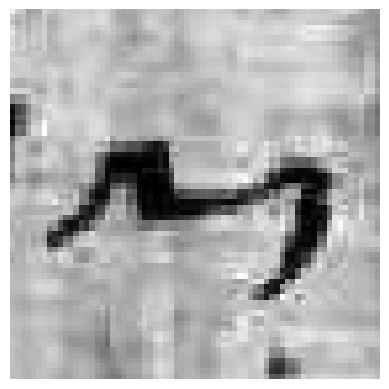

In [100]:
# Display the grayscale image
plt.imshow(X_gray[100000], cmap="gray")
plt.axis("off")
plt.show()

In [107]:
X_in = np.array(X_gray).reshape(len(X_gray), -1)

In [108]:
X_in.shape

(205797, 4900)

In [135]:
# Test-train split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets while preserving label balance
X_train, X_test, Y_train, Y_test = train_test_split(X_in, Y, test_size=0.1, stratify=Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, stratify=Y_train)

In [138]:
print("Train images shape:",X_train.shape)
print("Train labels shape:",Y_train.shape)
print("Test images shape:",X_test.shape)
print("Test labels shape:",Y_test.shape)
print("Validation images shape:",X_val.shape)
print("Validation labels shape:",Y_val.shape)

Train images shape: (166695, 4900)
Train labels shape: (166695, 24)
Test images shape: (20580, 4900)
Test labels shape: (20580, 24)
Validation images shape: (18522, 4900)
Validation labels shape: (18522, 24)


In [139]:
#Autoencoder Implementation

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

In [158]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [164]:
class CharacterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.FloatTensor(images)
        self.labels = torch.FloatTensor(labels)

        self.images = self.images.to(device)
        self.labels = self.labels.to(device)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [165]:
train_dataset = CharacterDataset(X_train, Y_train)
test_dataset = CharacterDataset(X_test, Y_test)
val_dataset = CharacterDataset(X_val, Y_val)

In [166]:
#Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, latent_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [192]:
input_dim = 4900  # Dimensionality of the input data
latent_dim = 100  # Dimensionality of the latent space

model = Autoencoder(input_dim, latent_dim)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/10], Train Loss: 803.7382, Test Loss: 351.6069
Epoch [2/10], Train Loss: 285.3252, Test Loss: 229.9557
Epoch [3/10], Train Loss: 200.6054, Test Loss: 170.9948
Epoch [4/10], Train Loss: 879.9964, Test Loss: 164.9378
Epoch [5/10], Train Loss: 162.8878, Test Loss: 165.6560
Epoch [6/10], Train Loss: 167.8165, Test Loss: 152.2255
Epoch [7/10], Train Loss: 163.4525, Test Loss: 157.1892
Epoch [8/10], Train Loss: 367.0767, Test Loss: 152.2707
Epoch [9/10], Train Loss: 149.6502, Test Loss: 146.6321
Epoch [10/10], Train Loss: 156.1581, Test Loss: 162.5281


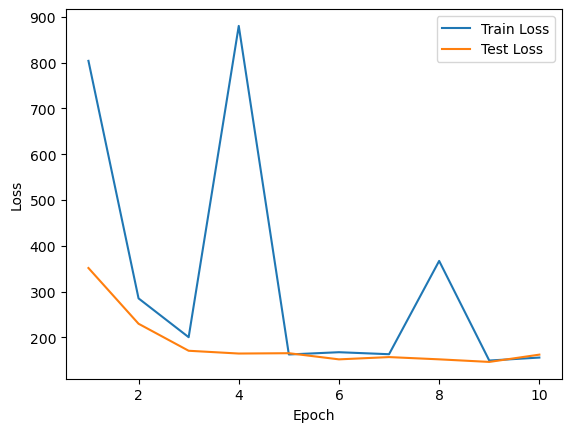

<All keys matched successfully>

In [193]:
num_epochs = 10
batch_size = 64
best_test_loss = float('inf')
best_model_state = None

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    test_loss = 0.0

    # Training
    model.train()
    for batch in train_loader:
        images, labels = batch

        # Forward pass
        reconstructions = model(images)
        loss = criterion(reconstructions, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch

            # Forward pass
            reconstructions = model(images)
            loss = criterion(reconstructions, images)

            test_loss += loss.item() * images.size(0)

        test_loss /= len(val_loader.dataset)
        test_losses.append(test_loss)

        # Check if current model has the lowest test loss so far
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = model.state_dict().copy()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Plotting train and test loss
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Load the best model state (lowest test loss)
model.load_state_dict(best_model_state)

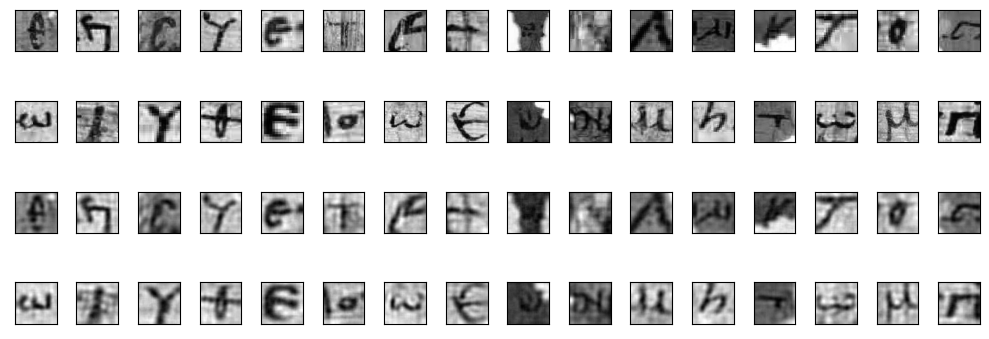

In [194]:
# Set the model to evaluation mode
model.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Get a batch of test data
test_batch = next(iter(test_loader))
test_images, _ = test_batch

# Pass the test data through the model
with torch.no_grad():
    reconstructions = model(test_images)

# Plot the original images and their reconstructions
fig, axes = plt.subplots(nrows=4, ncols=batch_size // 4, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    if i < batch_size // 2:
        # Plot original image
        ax.imshow(test_images[i].cpu().numpy().reshape(70, 70), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    else:
        # Plot reconstructed image
        ax.imshow(reconstructions[i - batch_size // 2].cpu().numpy().reshape(70, 70), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])


plt.tight_layout()
plt.show()